<h1 align=center>Capítulo 4 - Correspondência baseada em regras</h1>
<p align=center><img src=https://growvox.com/wp-content/uploads/2020/08/remarketing.png width=500></p>

**A extração de informações baseada em regras** é indispensável para qualquer pipeline de NLP. Certos tipos de entidades, como horas, datas e números de telefone, possuem formatos distintos que podem ser reconhecidos por um conjunto de regras, sem a necessidade de treinar modelos estatísticos.

Neste capítulo, você aprenderá a extrair rapidamente informações do texto combinando padrões e frases. Você usará **recursos morfológicos**, **tags POS**, **regex** e outros recursos spaCy para formar objetos padrão para alimentar os objetos **Matcher**. Você continuará com modelos estatísticos refinados com correspondência baseada em regras para elevar os modelos estatísticos a uma precisão melhor.

Ao final deste capítulo, você conhecerá uma parte vital da extração de informações. Você poderá extrair entidades de formatos específicos, bem como entidades específicas do seu domínio. Neste capítulo, abordaremos os seguintes tópicos principais:
* Correspondência baseada em token
* Phrase Matcher
* EntityRuler
* Combinando modelos spaCy e matchers

## Correspondência baseada em token
Até agora, exploramos os conceitos linguísticos sofisticados que requerem modelos estatísticos e seus usos com spaCy. Algumas tarefas NLU podem ser resolvidas de maneiras complicadas sem a ajuda de qualquer modelo estatístico. Uma dessas maneiras é o **regex**, que usamos para corresponder um conjunto predefinido de padrões ao nosso texto.

Uma regex (uma expressão regular) é uma sequência de caracteres que especifica um padrão de pesquisa. Uma regex descreve um conjunto de strings que segue o padrão especificado. Um regex pode incluir letras, dígitos e caracteres com significados especiais, como ?, . e *. A biblioteca interna do Python oferece excelente suporte para definir e combinar expressões regulares. Há outra biblioteca Python 3 chamada regex que pretende substituir **re** no futuro.

Os leitores que estão desenvolvendo ativamente aplicativos de NLP com Python definitivamente encontraram código regex e, melhor ainda, escreveram regex.

Como é uma regex, então? A regex a seguir corresponde às seguintes strings:
* Barack Obama
* Barack Obama
* Barack Hussein Obama
~~~python
reg = r"Barack\s(Hussein\s)?Obama"
~~~

Este padrão pode ser lido como: a string **Barack** pode ser seguida opcionalmente pela string **Hussein** (o caractere **?** em regex significa opcional, ou seja, **0** ou **1** ocorrência) e deve ser seguido pela string **Obama**. Os espaços entre palavras podem ser um único caractere de espaço, uma tabulação ou qualquer outro caractere de espaço em branco (**\s** corresponde a todos os tipos de caracteres de espaço em branco, incluindo o caractere de nova linha).

Não é muito legível, mesmo para um padrão tão curto e descomplicado, não é? Essa é a desvantagem do regex, conforme a seguir:

* Difícil de ler
* Difícil de depurar
* Propenso a erros com espaço, pontuação e caracteres numéricos

Por esses motivos, muitos engenheiros de software não gostam de trabalhar com regex em seu código de produção. spaCy fornece uma alternativa muito limpa, legível, de nível de produção e de manutenção: a classe **Matcher**. A classe **Matcher** pode corresponder nossas regras predefinidas à sequência de tokens em objetos **Doc** e **Span**; além disso, as regras podem se referir ao token ou seus atributos linguísticos (mais sobre esse assunto posteriormente nesta seção).

Vamos começar com um exemplo básico de como chamar a classe **Matcher**:

In [183]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_md')
doc = nlp("Good morning, I want to reserve a ticket.")
matcher = Matcher(nlp.vocab)

pattern = [{"LOWER": "good"},
           {"LOWER": "morning"},
           {"IS_PUNCT": True}]

matcher.add("morningGreeting", [pattern])
matches = matcher(doc)

for match_id, start, end in matches:
	m_span = doc[start:end]
	print(f"Início: {start} -- Final: {end} -- Texto SPAN: {m_span.text}")


Início: 0 -- Final: 3 -- Texto SPAN: Good morning,


Parece complicado, mas não se intimide, vamos repassar as linhas uma a uma:
* Importamos **spacy** na primeira linha; isso deve ser familiar.
* Na segunda linha, importamos a classe **Matcher** para usá-la no restante do código.
* Nas próximas linhas, criamos o objeto **nlp** como de costume e criamos o objeto **doc** com nossa frase de exemplo.
* Agora, preste atenção: um objeto **matcher** precisa ser inicializado com um objeto **Vocabulary**, então na linha 5 inicializamos nosso objeto **matcher** com o vocabulário do modelo de linguagem (esta é a maneira usual de fazer isso). O que vem a seguir é definir o padrão que queremos combinar. Aqui, definimos padrão como uma lista onde cada item da lista dentro de uma chave representa um objeto token.

Você pode ler a lista de padrões no snippet de código anterior da seguinte maneira:
1. Um token cujo texto em minúsculo é **good**
2. Um token cujo texto em minúsculo é **morning**
3. Um token que é pontuação (ou seja, o recurso **IS_PUNCT** é **True**)

Em seguida, precisamos introduzir esse padrão ao **matcher**; é isso que a **linha matcher.add()** faz. Na linha 7, introduzimos nosso padrão no objeto **matcher** e nomeamos essa regra como **morningGreeting**. Finalmente, podemos fazer a operação de correspondência na linha 8 chamando **matcher** no **doc**. Depois disso, examinamos o resultado que obtemos. Um resultado de partida é uma lista tríplice no formato (**ID do match**, **posição inicial**, **posição final**). Na linha final, iteramos sobre a lista de resultados e imprimimos a posição inicial, a posição final e o texto da correspondência do resultado.

Como você pode ter notado, o espaço em branco entre **Good** e **morning** não importava nada. Na verdade, poderíamos ter colocado dois espaços em branco no meio, escrito **Good morning**, e o resultado seria idêntico. Por quê? Porque o **Matcher** corresponde aos tokens e aos atributos do token. Um padrão sempre se refere a uma sequência contínua de objetos simbólicos, e cada item nas chaves corresponde a um objeto simbólico. Vamos voltar ao padrão no trecho de código anterior:

~~~python
pattern = [{"LOWER": "good"}, {"LOWER": "morning"},{"IS_PUNCT": True}]
~~~
Vemos que o resultado é sempre uma combinação de três tokens.

Podemos adicionar mais de um padrão? A resposta é sim. Vamos ver com um exemplo e também ver um exemplo de **match_id** da seguinte forma:

In [184]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_md")
doc = nlp("Good morning, I want to reserve a ticket. I will then say good evening!")
matcher = Matcher(nlp.vocab)

pattern1 = [
	{"LOWER": "good"},
	{"LOWER": "morning"},
	{"IS_PUNCT": True}
]

matcher.add("morningGreeting", [pattern1])

pattern2 = [
	{"LOWER": "good"},
	{"LOWER": "evening"},
	{"IS_PUNCT": True}
]

matcher.add("eveningGreeting", [pattern2])

matches = matcher(doc)

for match_id, start, end in matches:
	pattern_name = nlp.vocab.strings[match_id]
	m_span = doc[start:end]
	print(f"Padrão (Nome): {pattern_name}Início: {start} -- Final: {end} -- Texto SPAN: {m_span.text}")

Padrão (Nome): morningGreetingInício: 0 -- Final: 3 -- Texto SPAN: Good morning,
Padrão (Nome): eveningGreetingInício: 14 -- Final: 17 -- Texto SPAN: good evening!


Desta vez fizemos as coisas de forma um pouco diferente:
* Na linha 8, definimos um segundo padrão, novamente combinando três tokens, mas desta vez **evening** em vez de **morning**.
* Na próxima linha, adicionamos ao **matcher**. Neste ponto, o **matcher** contém 2 padrões: **morningGreeting** e **eveningGreeting**.
* Novamente, chamamos o **matcher** em nossa sentença e examinamos o resultado. Desta vez, a lista de resultados tem dois itens, **Good morning** e **good evening!**, correspondendo a dois padrões diferentes, **morningGreeting** e **eveningGreeting**.

No exemplo de código anterior, **pattern1** e **pattern2** diferem apenas por um token: **evening/morning**. Em vez de escrever dois padrões, podemos dizer **evening** ou **morning**? Podemos fazer isso também.

Aqui estão os atributos que o Matcher reconhece:

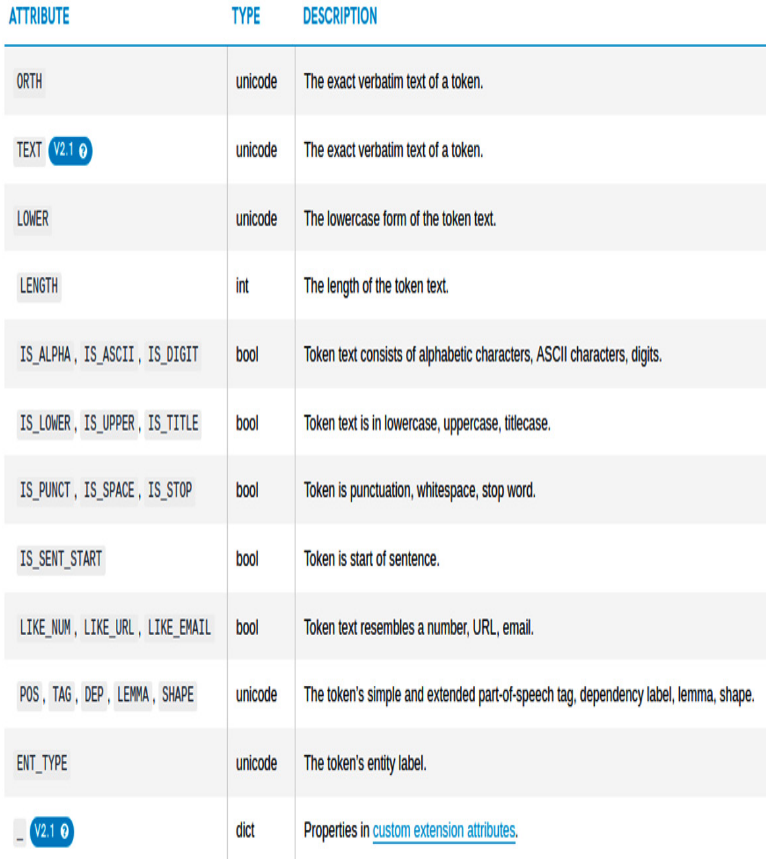

In [185]:
from IPython.display import Image
Image('images/matcher_attributes.PNG')

Vamos examinar os atributos um por um com alguns exemplos. Usamos **LOWER** nos exemplos anteriores; significa a forma minúscula do texto do token. **ORTH** e **TEXT** são semelhantes a **LOWER**: significam uma correspondência exata do texto do token, incluindo maiúsculas e minúsculas. Aqui está um exemplo:
~~~python
pattern = [{"TEXT": "Bill"}]
~~~

O código anterior corresponderá a **BIll**, mas não a **bill**. **LENGTH** é usado para especificar o comprimento do token. O código a seguir encontra todos os tokens de comprimento **1**:

In [186]:
doc = nlp("I bought a pineapple.")
matcher = Matcher(nlp.vocab)
pattern = [{"LENGTH": 1}]
matcher.add("onlyShort", [pattern])
matches = matcher(doc)
for mid, start, end in matches:
    print(start, end, doc[start:end])

0 1 I
2 3 a
4 5 .


O próximo bloco de atributos de token é **IS_ALPHA**, **IS_ASCII** e **IS_DIGIT**. Esses recursos são úteis para encontrar tokens numéricos e palavras *comuns* (que não incluem caracteres interessantes). O padrão a seguir corresponde a uma sequência de dois tokens, um número seguido por uma palavra comum:

In [187]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_md")
matcher = Matcher(nlp.vocab)
doc1 = nlp("I met him at 2 o'clock.")
doc2 = nlp("He brought me 2 apples.")
pattern = [{"IS_DIGIT": True},{"IS_ALPHA": True}]

matcher.add("numberAndPlainWord", [pattern])
matchs = matcher(doc1)
for mid, start, end in matchs:
    print(start, end, doc[start:end])

In [188]:
matches = matcher(doc2)
len(matches)

1

In [189]:
mid, start, end = matches[0]
print(start, end, doc2[start:end])

3 5 2 apples


No segmento de código anterior, **2 o'clock** não correspondeu ao padrão porque **o´clock** contém um apóstrofo, que não é um caractere alfabético (caracteres alfabéticos são dígitos, letras e o caractere sublinhado). **2 apples** combinadas porque **apples** só possuem letras.

**IS_LOWER**, **IS_UPPER** e **IS_TITLE** são atributos úteis para reconhecer o *case token*. **IS_UPPER** será **True** se o token for todo em letras maiúsculas e **IS_TITLE** será **True** se o token começar com letra maiúscula. **IS_LOWER** será **True** se o token for todo em letras minúsculas. Imagine que queremos encontrar palavras enfatizadas em um texto; uma maneira é procurar os tokens com todas as letras maiúsculas. Os tokens maiúsculos geralmente têm pesos em modelos de análise de sentimento.

In [190]:
doc = nlp("Take me out of your SPAM list. We never asked you to contact me. If you write again we'll SUE!!!!")
pattern = [{"IS_UPPER": True}]
matcher.add("capitals", [pattern])
matches = matcher(doc)
for mid, start, end in matches:
	print(start, end, doc[start:end])

5 6 SPAM
22 23 SUE


**IS_PUNCT**, **IS_SPACE** e **IS_STOP** geralmente são usados em padrões que incluem alguns tokens auxiliares e correspondem a tokens de pontuação, espaço e stopword (stopwords são palavras comuns de uma linguagem que não carregam muita informação, como *a*, *an* e *the* em inglês).

**IS_SENT_START** é outro atributo útil; ele corresponde aos tokens de início de sentença. Aqui está um padrão para frases que começam com *can* e a segunda palavra tem uma primeira letra maiúscula:

In [191]:
doc1 = nlp("Can you swim?")
doc2 = nlp("Can Sally swim?")
pattern = [{"IS_SENT_START": True, "LOWER": "can"},
           {"IS_TITLE": True}]
matcher.add("canThenCapitalized", [pattern])
matcher(doc1) # Com a segunda palavra não começa com Maiúsculo, então é <None>

[]

In [192]:
matches = matcher(doc2)
len(matches)

1

In [193]:
mid, start, end = matches[0]
print(start, end, doc2[start:end]) # Com a segunda palavra começa com Maiúsculo, então vemos o retorno

0 2 Can Sally


Aqui, fizemos uma coisa diferente: colocamos dois atributos em uma chave. Neste exemplo, o primeiro item no **padrão** significa que um token que é o primeiro token da frase e cujo texto minúsculo é *can*. Podemos adicionar quantos atributos quisermos. Por exemplo, **{"IS_SENT_START": False, "IS_TITLE": True, "LOWER": "bill"}** é um dicionário de atributos completamente válido e descreve um token em maiúsculas, não o primeiro token da frase, e tem o conta de texto. Portanto, é o conjunto de instâncias de **Bill** que não aparece como a primeira palavra de uma frase.

**LIKE_NUM**, **LIKE_URL** e **LIKE_EMAIL** são atributos relacionados novamente à forma do token. Esses atributos correspondem a tokens que se parecem com números, URLs e e-mails.

Embora o código anterior pareça curto e simples, os atributos de forma podem ser salva-vidas em aplicativos NLU. Na maioria das vezes, você não precisa de nada além de combinações inteligentes de forma e atributos linguísticos.

Depois de ver os atributos de forma, vamos ver os atributos linguísticos **POS, TAG, DEP, LEMMA e SHAPE**. Você viu esses atributos de token no capítulo anterior; agora vamos usá-los na correspondência de token. O trecho de código a seguir identifica frases que começam com um verbo auxiliar:

In [194]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_md")
matcher = Matcher(nlp.vocab)


doc = nlp("Will you go there?")
pattern = [{"IS_SENT_START": True, "TAG": "MD"}]
matcher.add('tagMD',[pattern])
matches = matcher(doc)
len(matches)

1

In [195]:
mid, start, end = matches[0]
print(start, end, doc[start:end])

0 1 Will


In [196]:
doc1 = nlp("I go there.")
matcher(doc1)

[]

**MD** é a tag para verbos *modais e auxiliares*. O trecho de código anterior é uma maneira padrão de encontrar frases de perguntas sim/não. Nesses casos, geralmente procuramos frases que começam com um verbo modal ou auxiliar.

> #### DICA PROFISSIONAL
> Não tenha medo de trabalhar com tags de **partes de fala (POS)**, elas são suas amigas e podem salvar vidas em algumas situações. Quando queremos extrair o significado de uma palavra, geralmente combinamos **TEXT/LEMMA** com **POS/TAG**. Por exemplo, a palavra *match* é ir junto quando é um verbo ou pode ser uma ferramenta de inicialização quando é um substantivo. Neste caso, fazemos a distinção da seguinte forma:
> ~~~python
> {"LEMMA": "match", "POS": "VERB"} e
> {"LEMMA": "match", "POS": "NOUN"}.
> ~~~
> Da mesma forma, você pode combinar outros recursos linguísticos com atributos de forma de token para certificar-se de extrair apenas o padrão desejado.

Veremos mais exemplos de combinação de recursos linguísticos com a classe **Matcher** nas próximas seções. Agora, vamos explorar mais recursos do Matcher.

### Suporte de sintaxe estendido

O Matcher permite que os padrões sejam mais expressivos, permitindo alguns operadores dentro das chaves. Esses operadores são para comparação estendida e são semelhantes aos operadores **in, not in** e de comparação do Python. Segue a lista dos operadores:

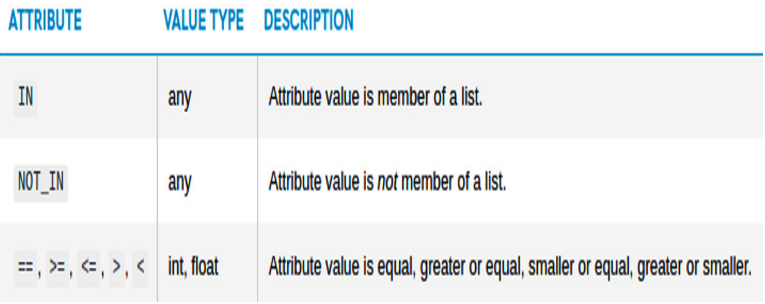

In [197]:
Image('images/operador_sintaxe.PNG')

Em nosso primeiro exemplo, combinamos **good evening** e **good morning** com dois padrões diferentes. Agora, podemos combinar good morning/evening com um padrão com a ajuda de **IN** da seguinte forma:

In [198]:
doc = nlp("Good morning, I'm here. I'll say good evening!!")
pattern = [{"LOWER": "good"},
           {"LOWER": {"IN": ["morning", "evening"]}},
           {"IS_PUNCT": True}]

matcher.add("greetings", [pattern])
matches = matcher(doc)
for mid, start, end in matches:
    print(start, end, doc[start:end])

0 3 Good morning,
10 13 good evening!


Os operadores de comparação geralmente acompanham o atributo **LENGTH**. Aqui está um exemplo de como encontrar tokens longos:

In [199]:
doc = nlp("I suffered from Trichotillomania when I was in college. The doctor prescribed me Psychosomatic medicine.")
pattern = [{"LENGTH": {">=" : 10}}]
matcher.add("longWords", [pattern])
matches = matcher(doc)
for mid, start, end in matches:
    print(start, end, doc[start:end])

3 4 Trichotillomania
12 13 prescribed
14 15 Psychosomatic


Eram palavras divertidas de processar! Agora, vamos passar para outro recurso muito prático dos padrões Matcher, operadores semelhantes a regex.

### Operadores tipo Regex
No início do capítulo, apontamos que a classe **Matcher** do *spaCy* oferece um equivalente mais limpo e legível às operações regex, na verdade muito mais limpo e muito mais legível. As operações regex mais comuns são correspondência opcional (**?**), correspondência pelo menos uma vez (**+**) e correspondência 0 ou mais vezes(*). O SpaCy's Matcher também oferece esses operadores usando a seguinte sintaxe:

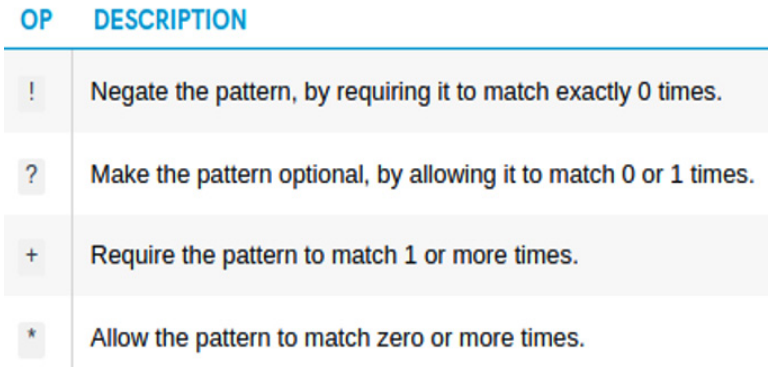

In [200]:
Image('images/OP_key.PNG')

O primeiro exemplo de regex deste capítulo correspondia ao primeiro nome de Barack Obama, sendo o nome do meio opcional. A regex ficou assim:
~~~python
R"Barack\s(Hussein\s)?Obama
~~~

O **?** operador após **Hussein** significa que o padrão entre colchetes é opcional, portanto, essa regex corresponde a **Barack Obama** e **Barack Hussein Obama**. Nós usamos o **?** operador em um padrão Matcher da seguinte forma:

In [201]:
doc1 = nlp("Barack Obama visited France.")
doc2 = nlp("Barack Hussein Obama visited France.")
pattern = [{"LOWER": "barack"},
           {"LOWER": "hussein", "OP": "?"},
           {"LOWER": "obama"}]
matcher.add("obamaNames", [pattern])
matches = matcher(doc1)
for mid, start, end in matches:
    print(start, end, doc1[start:end])

0 2 Barack Obama


In [202]:
matches = matcher(doc2)
for mid, start, end in matches:
	print(start, end, doc2[start:end])

0 3 Barack Hussein Obama


Aqui, usando o **"OP": "?"** no segundo item da lista, tornamos esse token opcional. O **matcher** escolheu **Barack Obama** no primeiro objeto do documento e **Barack Hussein Obama** no segundo como resultado.

Apontamos anteriormente que os operadores **+** e **\*** têm o mesmo significado que suas contrapartes regex. + significa que o token deve ocorrer pelo menos uma vez e * significa que o token pode ocorrer 0 ou mais vezes. Vejamos alguns exemplos:

In [203]:
doc1 = nlp("Hello hello hello, how are you?")
doc2 = nlp("Hello, how are you?")
doc3 = nlp("How are you?")
pattern = [{"LOWER":{"IN": ["hello", "hi", "hallo"]},"OP":"*"},
           {"IS_PUNCT": True}]

matcher.add("greetings", [pattern])
for mid, start, end in matcher(doc1):
	print(start, end, doc1[start:end])

0 4 Hello hello hello,
1 4 hello hello,
2 4 hello,
3 4 ,
7 8 ?


In [204]:
for mid, start, end in matcher(doc2):
    print(start, end, doc2[start:end])

0 2 Hello,
1 2 ,
5 6 ?


In [205]:
for mid, start, end in matcher(doc3):
	print(start, end, doc3[start:end])

3 4 ?
